# Architectural Basics

Write MNIST code such that:
- 99.4% validation accuracy
- Parameters exactly between 12000 to 18000
- Used exactly 19 epochs
- Have used BN, Dropout, a Fully connected layer, have used GAP. 
- Dropout must have 0.069 as the dropout value
- Batch size must be exactly 128
- Add random rotation to your images between -5 to +5 degrees

# Import Libraries

Let's first import all the necessary libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR,OneCycleLR

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        #Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,padding=1,bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.069),

            nn.Conv2d(8, 16, 3,padding=1,bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.069),

            nn.Conv2d(16, 32, 3,bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.069),
        
        )

        #Transition Block 
        self.trans1 = nn.Sequential(

            nn.MaxPool2d(2, 2), 

            # 1x1 convolution
            nn.Conv2d(32, 8, 1,bias=False), 
            nn.ReLU(),
        )

        #Block 2
        self.conv2 =  nn.Sequential(

            nn.Conv2d(8, 16, 3,bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.069),

            nn.Conv2d(16, 32, 3,bias=False),  
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.069), 
        )

        #Transition Block (1x1)
        self.trans2 = nn.Sequential(

            # 1x1 convolution
            nn.Conv2d(32, 8, 1,bias=False), 
            nn.ReLU(),
        )

        #Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, 3,bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.069), 

            
        )

        # GAP Layer
        self.avg_pool = nn.Sequential(
            nn.Conv2d(16, 16, 3,bias=False), 
            nn.AvgPool2d(3, stride=1, padding=0)
        )

        #Fully Connected Layer
        self.fc = nn.Linear(16*3*3,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 32, 26, 26]           4,608
             ReLU-10           [-1, 32, 26, 26]               0
      BatchNorm2d-11           [-1, 32, 26, 26]              64
        Dropout2d-12           [-1, 32, 26, 26]               0
        MaxPool2d-13           [-1, 32, 13, 13]               0
           Conv2d-14            [-1, 8,

## The Model

In [15]:
model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.069, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.069, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.069, inplace=False)
  )
  (trans1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bi

## Model Parameters

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 17,250 trainable parameters


## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

In [12]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-5.0, 5.0)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, **kwargs)



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Training and Testing Loop

In [17]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss=0
    correct = 0
    # processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        #processed += len(data)

        pbar.set_description(desc= f'epoch={epoch} loss={loss.item():.10f} batch_id={batch_idx:05d}')
    #print( f'Epoch {epoch} - \nTrain set : loss={loss.item()} batch_id={batch_idx}')
    train_loss = epoch_loss / len(train_loader)
    train_acc=100.*correct/len(train_loader.dataset)

    return train_loss,train_acc


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc=100. * correct / len(test_loader.dataset)
    return test_loss,test_acc

## Let's write train and test the model

In [18]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)

train_loss_values = []
test_loss_values = []
train_accuracy=[]
test_accuracy=[]

scheduler = StepLR(optimizer, step_size=10, gamma=0.01)

for epoch in range(1, 20):
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0490, Accuracy: 9846/10000 (98.46%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0393, Accuracy: 9878/10000 (98.78%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0365, Accuracy: 9882/10000 (98.82%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0287, Accuracy: 9905/10000 (99.05%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0299, Accuracy: 9904/10000 (99.04%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0270, Accuracy: 9901/10000 (99.01%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0282, Accuracy: 9914/10000 (99.14%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0224, Accuracy: 9924/10000 (99.24%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0188, Accuracy: 9943/10000 (99.43%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)



  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)



epoch=19 loss=0.0200052019 batch_id=00468: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)



## Ploting the loss

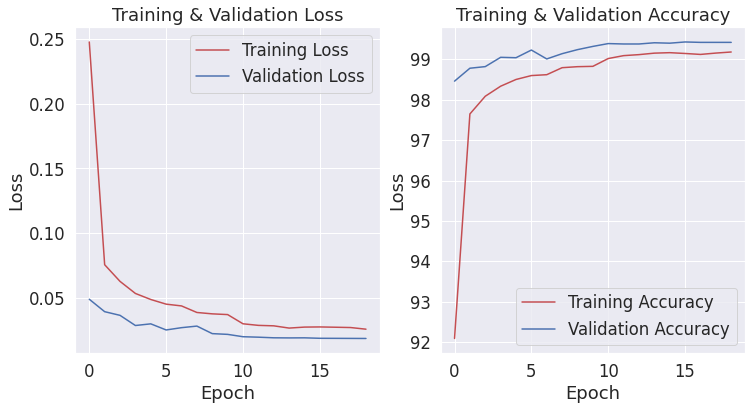

In [19]:
import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(np.array(train_loss_values), 'r', label="Training Loss")
ax1.plot(np.array(test_loss_values), 'b', label="Validation Loss")

# Label the plot.
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(np.array(train_accuracy), 'r', label="Training Accuracy")
ax2.plot(np.array(test_accuracy), 'b', label="Validation Accuracy")

# Label the plot.
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.show()

## Final Results

- Model has 17,250 parametes
- Added Drop out of 0.069 
- The model was trained with a learning rate of 0.015 amd momentum of 0.9
- Network was trained for exactly 19 epochs with batch size of 128
- Achieved a test accuracy of 99.4% from Epoch 14,15,16,17,18 and 19th.
